In [1]:
import sys
sys.path.append('../../Pyfiles')

import numpy as np
from sklearn.utils import shuffle
import matplotlib.pyplot as plt

data1Path = r'../../dataset/data0test.txt'
data1Label = r'../../dataset/data0testlabel.txt'

dataCoords = np.loadtxt(data1Path)
dataLabels = np.loadtxt(data1Label)

In [2]:
# Make a data structure which is easier to work with
# for shuffling. 
# Also, notice we change the data labels from {0, 1} to {-1, +1}
data = list(zip(dataCoords, 2*dataLabels-1))
shuffled_data = shuffle(data)

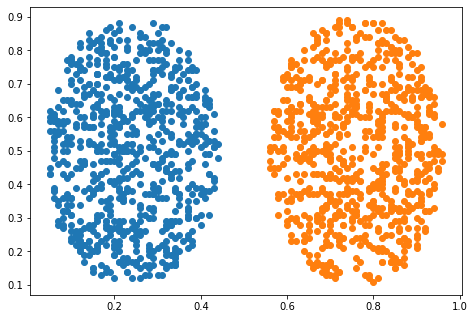

In [3]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

ax.plot(np.ravel(dataCoords[np.where(dataLabels == 0)])[::2],
np.ravel(dataCoords[np.where(dataLabels == 0)])[1::2], ls='', marker='o')

ax.plot(np.ravel(dataCoords[np.where(dataLabels == 1)])[::2],
np.ravel(dataCoords[np.where(dataLabels == 1)])[1::2], ls='', marker='o')

In [4]:
from IPython.display import Image

# Loss function Two-Qubit

Loss is calculated with a simple two-qubit gate. First, the data is embedded into Rx rotation with pi/4 rotation of Ry and Rz. The parameterized quantum circuit is placed after the embedding. We used same structure of the circuit1 from the paper to check the convergence.

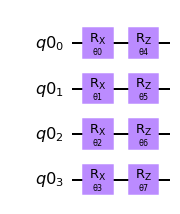

In [5]:
from circuits import *
from qiskit.circuit import Parameter

#circuit 1
qr = QuantumRegister(4)
qc = QuantumCircuit(qr)

theta=[]
for i in range(62):
    theta.append((Parameter('θ'+str(i))))
qc=circuit1(qc,qr,theta,1,0)
qc.draw('mpl')

In [6]:
#load the simulation functcions from the quantumcircuit.py file

from quantumcircuit import *

#location,label,param,[circuit#,layer]
loss_qubitF([0.5,0.5],-1,[0,0,0,-5,0,0,0,0],[0,1])


0

## [SPSA method](https://en.wikipedia.org/wiki/Simultaneous_perturbation_stochastic_approximation)

SPSA is an algorithm used in numerical optimization.

Consider a loss function $L(\mathbf{x})$. In order to optimize $L$, SPSA iteratively optimizes the parameters of the loss function according to the following update rule:

$$\mathbf{y}_{n+1} = \mathbf{y}_{n} - a_{n}\widehat{\Delta L}_{n}(\mathbf{y}_{n}),$$

where $\widehat{\Delta L}_{n}(\mathbf{y}_{n}))$ is an estimate of the gradient at $\mathbf{y}_{n}$.

How SPSA calculates that gradient is by using a finite-difference rule on random perturbations of component of the parameter vector.
    $$\left( \widehat{\Delta L}_{n}(\mathbf{y}_{n}))\right)_{j} = \frac{L(\mathbf{y}_{n} + c_{n}\boldsymbol{\Delta}_{n}) - L(\mathbf{y}_{n} - c_{n}\boldsymbol{\Delta}_{n}) }{c_{n}\left(\boldsymbol{\Delta}_{n}\right)_{j}}$$
    
That is at each iteration, SPSA generates a random perturbation $\boldsymbol{\Delta}_{n}$, and does a finite-difference rule with that perturbation.

In order for the algorithm to converge, the random perturbation $\boldsymbol{\Delta}_{n}$ and finite-difference coefficients $c_{n}$ must satisfy certain properties (see the Wikipedia article linked to in the title). Importantly $c_{n}$ must tend to 0 as $n$ increases, and the size of the random fluctuations $\boldsymbol{\Delta}_{n}$ must also be bounded.

According to the wikipedia article, the coefficients $a_{n}$ and $c_{n}$ should look something like

$$c_{n} = \frac{c}{n^\gamma}~~\text{and}~~a_{n} = \frac{a}{n}.$$

In [21]:
#load the SPSA optimizer from the optimizer.py file
from optimizer import *

# Test the convergence of 100 data point

To have sanity check, we take 100 data and run the optimization.

In [24]:
c = 0.5
a = 0.5

# Do the updates
lossList = []
coeffsList = []
paramsList = []
accuracyList = []

np.random.seed(2)
currentParams = pi*np.random.uniform(size=8)
for j in range(10):      
    
    cj = c/(j+1)**(1/2)
    aj = a/(j+1)

    
    # Grab a subset of the data for minibatching
    #np.random.seed(j)
    np.random.seed(2)
    #data_ixs = np.random.choice(len(shuffled_data), size=len(shuffled_data))
    data_ixs = np.random.choice(len(data), size=100)
    
    # Evaluate the loss over that subset
    # We include a regularization term at the end 
    L = lambda x: np.sum([loss_qubitF(data[j][0],data[j][1],x,[0,1]) for j in data_ixs])/len(data_ixs) 
    
    lossList.append(L(currentParams))
    coeffsList.append((cj, aj))
    paramsList.append(currentParams)
    accuracyList.append(np.sum([predict_qubitF(data[j][0],currentParams,[0,1]) ==data[j][1] for j in data_ixs])/len(data_ixs))
    print(j,"th iteration L=",lossList[-1],"Accuracy =",accuracyList[-1])
    currentParams = SPSA_update(L, currentParams, aj, cj)     

0 th iteration L= 0.14 Accuracy = 0.82
1 th iteration L= 0.3 Accuracy = 0.76
2 th iteration L= 0.38 Accuracy = 0.69
3 th iteration L= 0.82 Accuracy = 0.69
4 th iteration L= 0.14 Accuracy = 0.83
5 th iteration L= 0.16 Accuracy = 0.81
6 th iteration L= 0.3 Accuracy = 0.78
7 th iteration L= 0.22 Accuracy = 0.83
8 th iteration L= 0.22 Accuracy = 0.82
9 th iteration L= 0.16 Accuracy = 0.82


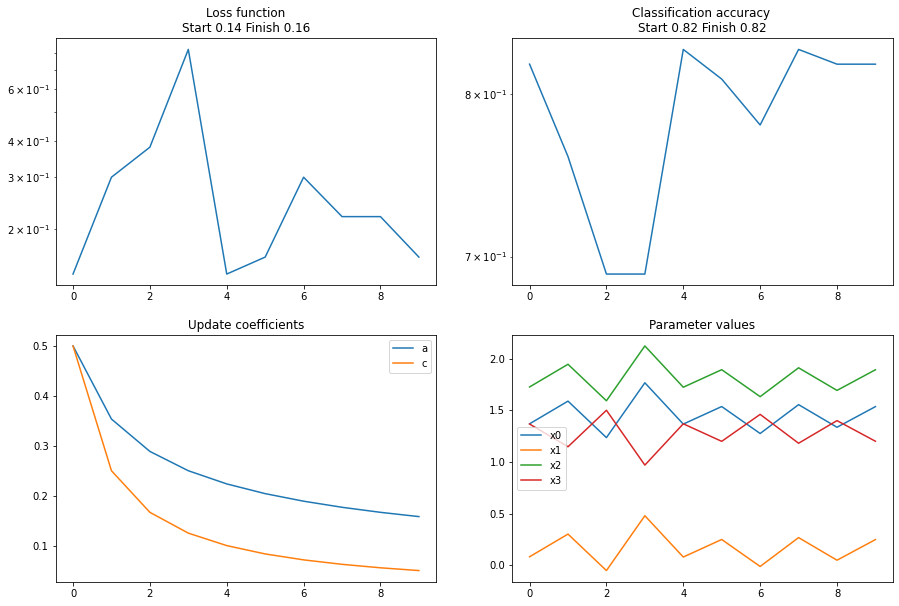

In [25]:
fig = plt.figure(figsize=(15, 10))

ax = fig.add_subplot(2, 2, 1)
ax.plot(lossList)
ax.set_title('Loss function\nStart {0} Finish {1}'.format(np.round(lossList[0], 3), np.round(lossList[-1], 3)))
ax.set_yscale('log')

ax = fig.add_subplot(2, 2, 2)
ax.plot(accuracyList)
ax.set_title('Classification accuracy \nStart {0} Finish {1}'.format(np.round(accuracyList[0], 3), np.round(accuracyList[-1], 3)))
ax.set_yscale('log')

ax = fig.add_subplot(2, 2, 3)
ax.plot([c[0] for c in coeffsList], label='a')
ax.plot([c[1] for c in coeffsList], label='c')
ax.legend(loc=0)
ax.set_title('Update coefficients')

ax = fig.add_subplot(2, 2, 4)
for j in range(4):
    ax.plot([X[j] for X in paramsList], label='x{0}'.format(j))
ax.legend(loc=0)
ax.set_title('Parameter values')
ax.legend(loc=0)

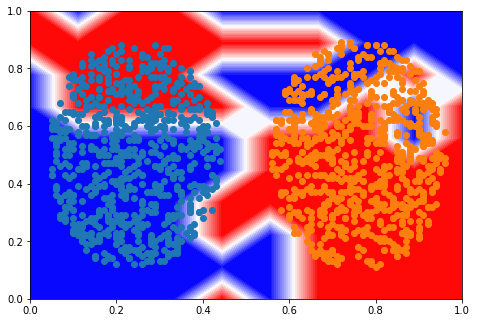

In [27]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.plot(np.ravel(dataCoords[np.where(dataLabels == 0)])[::2],
np.ravel(dataCoords[np.where(dataLabels == 0)])[1::2], ls='', marker='o')

ax.plot(np.ravel(dataCoords[np.where(dataLabels == 1)])[::2],
np.ravel(dataCoords[np.where(dataLabels == 1)])[1::2], ls='', marker='o')

X = np.linspace(0, 1, num=10)
Z = np.zeros((len(X), len(X)))

# Contour map
for j in range(len(X)):
    for k in range(len(X)):
        # Fill Z with the labels (numerical values)
        # the inner loop goes over the columns of Z,
        # which corresponds to sweeping x-values
        # Therefore, the role of j,k is flipped in the signature
        Z[j, k] = predict_qubitF( np.array([X[k], X[j]]),currentParams,[0,1])
        
ax.contourf(X, X, Z, cmap='bwr', levels=30)

# Different circuit

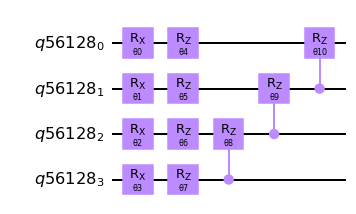

In [32]:
#circuit 2
qr = QuantumRegister(4)
qc = QuantumCircuit(qr)

theta=[]
for i in range(62):
    theta.append((Parameter('θ'+str(i))))
qc=circuit3(qc,qr,theta,1,0)
qc.draw('mpl')

In [33]:
data1Path = r'../../dataset/data1a.txt'
data1Label = r'../../dataset/data1alabel.txt'

dataCoords = np.loadtxt(data1Path)
dataLabels = np.loadtxt(data1Label)

# Make a data structure which is easier to work with
# for shuffling. 
# Also, notice we change the data labels from {0, 1} to {-1, +1}
data = list(zip(dataCoords, 2*dataLabels-1))
shuffled_data = shuffle(data)

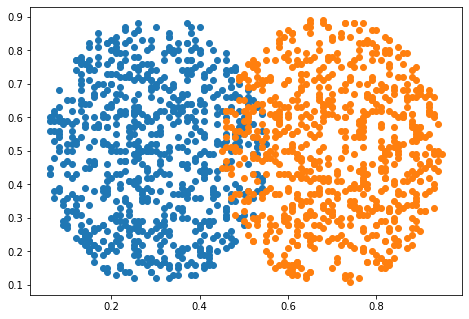

In [34]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

ax.plot(np.ravel(dataCoords[np.where(dataLabels == 0)])[::2],
np.ravel(dataCoords[np.where(dataLabels == 0)])[1::2], ls='', marker='o')

ax.plot(np.ravel(dataCoords[np.where(dataLabels == 1)])[::2],
np.ravel(dataCoords[np.where(dataLabels == 1)])[1::2], ls='', marker='o')

In [36]:
c = 1
a = 1

# Do the updates
lossList = []
coeffsList = []
paramsList = []
accuracyList = []

np.random.seed(2)
currentParams = pi*np.random.uniform(size=12)
for j in range(10):      
    
    cj = c/(j+1)**(1/2)
    aj = a/(j+1)
    
    # Grab a subset of the data for minibatching
    #np.random.seed(j)
    np.random.seed(3)
    #data_ixs = np.random.choice(len(shuffled_data), size=len(shuffled_data))
    data_ixs = np.random.choice(len(data), size=100)
    
    # Evaluate the loss over that subset
    # We include a regularization term at the end 
    L = lambda x: np.sum([loss_qubitF(data[j][0],data[j][1],x,[2,1]) for j in data_ixs])/len(data_ixs)
    
    lossList.append(L(currentParams))
    coeffsList.append((cj, aj))
    paramsList.append(currentParams)
    accuracyList.append(np.sum([predict_qubitF(data[j][0],currentParams,[2,1]) ==data[j][1] for j in data_ixs])/len(data_ixs))
    print(j,"th iteration L=",lossList[-1],"Accuracy =",accuracyList[-1])
    currentParams = SPSA_update(L, currentParams, aj, cj)     

0 th iteration L= 0.36 Accuracy = 0.74
1 th iteration L= 0.28 Accuracy = 0.68
2 th iteration L= 0.24 Accuracy = 0.76
3 th iteration L= 0.32 Accuracy = 0.78
4 th iteration L= 0.34 Accuracy = 0.75
5 th iteration L= 0.28 Accuracy = 0.81
6 th iteration L= 0.22 Accuracy = 0.77
7 th iteration L= 0.28 Accuracy = 0.77
8 th iteration L= 0.22 Accuracy = 0.75
9 th iteration L= 0.22 Accuracy = 0.79


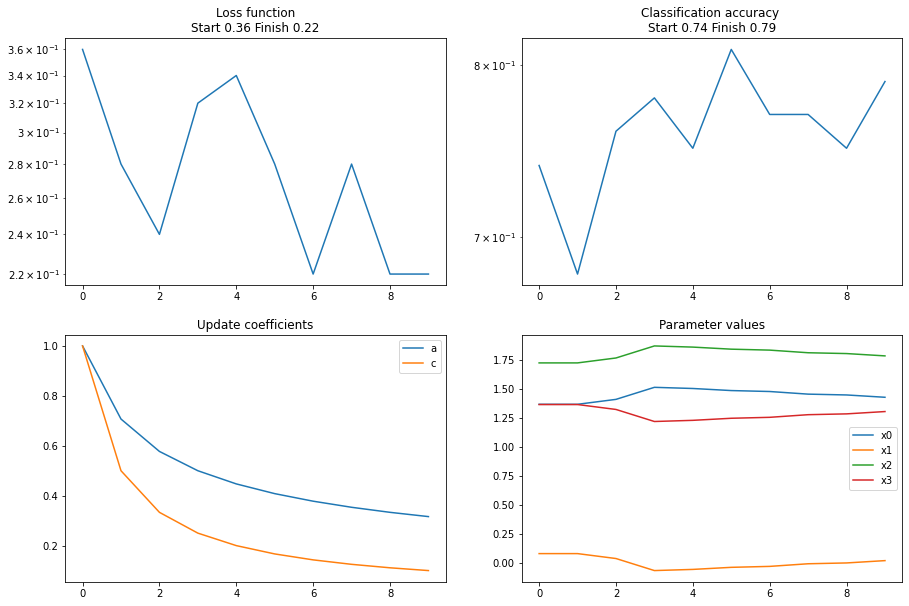

In [37]:
fig = plt.figure(figsize=(15, 10))

ax = fig.add_subplot(2, 2, 1)
ax.plot(lossList)
ax.set_title('Loss function\nStart {0} Finish {1}'.format(np.round(lossList[0], 3), np.round(lossList[-1], 3)))
ax.set_yscale('log')

ax = fig.add_subplot(2, 2, 2)
ax.plot(accuracyList)
ax.set_title('Classification accuracy \nStart {0} Finish {1}'.format(np.round(accuracyList[0], 3), np.round(accuracyList[-1], 3)))
ax.set_yscale('log')

ax = fig.add_subplot(2, 2, 3)
ax.plot([c[0] for c in coeffsList], label='a')
ax.plot([c[1] for c in coeffsList], label='c')
ax.legend(loc=0)
ax.set_title('Update coefficients')

ax = fig.add_subplot(2, 2, 4)
for j in range(4):
    ax.plot([X[j] for X in paramsList], label='x{0}'.format(j))
ax.legend(loc=0)
ax.set_title('Parameter values')
ax.legend(loc=0)

In [38]:
currentParams

array([1.4429145 , 0.00825354, 1.80001172, 1.29440951, 1.24742828,
       1.11097357, 0.71611877, 2.01869324, 0.8681968 , 0.76506649,
       2.02454561, 1.5891528 ])

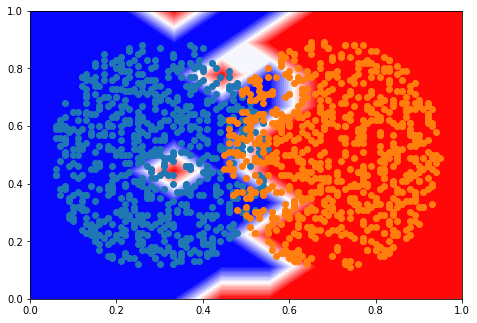

In [39]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.plot(np.ravel(dataCoords[np.where(dataLabels == 0)])[::2],
np.ravel(dataCoords[np.where(dataLabels == 0)])[1::2], ls='', marker='o')

ax.plot(np.ravel(dataCoords[np.where(dataLabels == 1)])[::2],
np.ravel(dataCoords[np.where(dataLabels == 1)])[1::2], ls='', marker='o')

X = np.linspace(0, 1, num=10)
Z = np.zeros((len(X), len(X)))

# Contour map
for j in range(len(X)):
    for k in range(len(X)):
        # Fill Z with the labels (numerical values)
        # the inner loop goes over the columns of Z,
        # which corresponds to sweeping x-values
        # Therefore, the role of j,k is flipped in the signature
        Z[j, k] = predict_qubitF( np.array([X[k], X[j]]),currentParams,[1,1])
        
ax.contourf(X, X, Z, cmap='bwr', levels=30)

# Another example

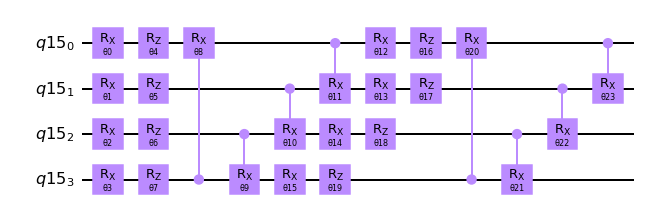

In [11]:
#circuit 1
qr = QuantumRegister(4)
qc = QuantumCircuit(qr)

theta=[]
for i in range(62):
    theta.append((Parameter('θ'+str(i))))
qc=circuit19(qc,qr,theta,2,0)
qc.draw('mpl')

In [12]:
data1Path = r'../../dataset/data2c.txt' 
data1Label = r'../../dataset/data2clabel.txt'

dataCoords = np.loadtxt(data1Path)
dataLabels = np.loadtxt(data1Label)

In [13]:
# Make a data structure which is easier to work with
# for shuffling. 
# Also, notice we change the data labels from {0, 1} to {-1, +1}
data = list(zip(dataCoords, 2*dataLabels-1))
shuffled_data = shuffle(data)

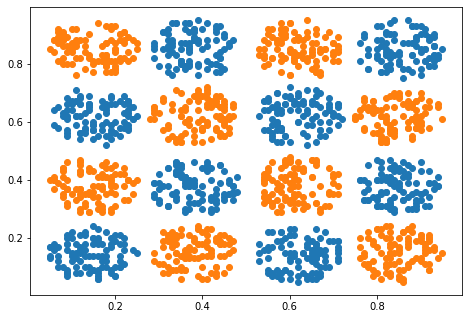

In [14]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

ax.plot(np.ravel(dataCoords[np.where(dataLabels == 0)])[::2],
np.ravel(dataCoords[np.where(dataLabels == 0)])[1::2], ls='', marker='o')

ax.plot(np.ravel(dataCoords[np.where(dataLabels == 1)])[::2],
np.ravel(dataCoords[np.where(dataLabels == 1)])[1::2], ls='', marker='o')

In [22]:
c = 1
a = 1

# Do the updates
lossList = []
coeffsList = []
paramsList = []
accuracyList = []

np.random.seed(2)
currentParams = 2*np.random.uniform(size=40)
for j in range(30):      
    
    cj = c/(j+1)**(1/4)
    aj = a/(j+1)
    
    # Grab a subset of the data for minibatching
    #np.random.seed(j)
    np.random.seed(3)
    #data_ixs = np.random.choice(len(shuffled_data), size=len(shuffled_data))
    data_ixs = np.random.choice(len(data), size=100)
    
    # Evaluate the loss over that subset
    # We include a regularization term at the end 
    L = lambda x: np.sum([loss_qubitF(data[j][0],data[j][1],x,[18,2]) for j in data_ixs])/len(data_ixs)
    
    lossList.append(L(currentParams))
    coeffsList.append((cj, aj))
    paramsList.append(currentParams)
    accuracyList.append(np.sum([predict_qubitF(data[j][0],currentParams,[18,2]) ==data[j][1] for j in data_ixs])/len(data_ixs))
    print(j,"th iteration L=",lossList[-1],"Accuracy =",accuracyList[-1])
    currentParams = SPSA_update(L, currentParams, aj, cj)     

0 th iteration L= 1.0 Accuracy = 0.53


KeyboardInterrupt: 

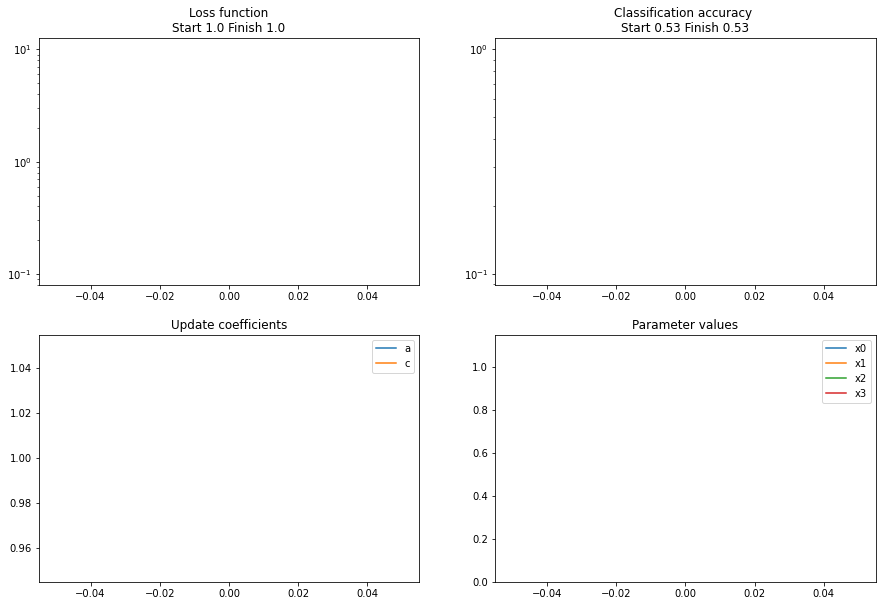

In [23]:
fig = plt.figure(figsize=(15, 10))

ax = fig.add_subplot(2, 2, 1)
ax.plot(lossList)
ax.set_title('Loss function\nStart {0} Finish {1}'.format(np.round(lossList[0], 3), np.round(lossList[-1], 3)))
ax.set_yscale('log')

ax = fig.add_subplot(2, 2, 2)
ax.plot(accuracyList)
ax.set_title('Classification accuracy \nStart {0} Finish {1}'.format(np.round(accuracyList[0], 3), np.round(accuracyList[-1], 3)))
ax.set_yscale('log')

ax = fig.add_subplot(2, 2, 3)
ax.plot([c[0] for c in coeffsList], label='a')
ax.plot([c[1] for c in coeffsList], label='c')
ax.legend(loc=0)
ax.set_title('Update coefficients')

ax = fig.add_subplot(2, 2, 4)
for j in range(4):
    ax.plot([X[j] for X in paramsList], label='x{0}'.format(j))
ax.legend(loc=0)
ax.set_title('Parameter values')
ax.legend(loc=0)

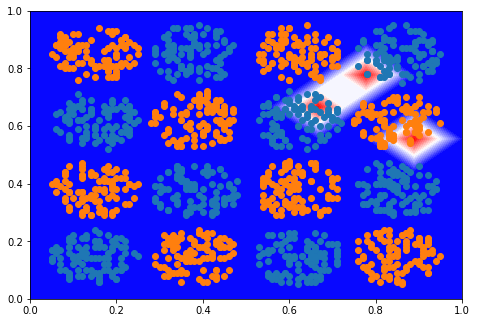

In [24]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.plot(np.ravel(dataCoords[np.where(dataLabels == 0)])[::2],
np.ravel(dataCoords[np.where(dataLabels == 0)])[1::2], ls='', marker='o')

ax.plot(np.ravel(dataCoords[np.where(dataLabels == 1)])[::2],
np.ravel(dataCoords[np.where(dataLabels == 1)])[1::2], ls='', marker='o')

X = np.linspace(0, 1, num=10)
Z = np.zeros((len(X), len(X)))

# Contour map
for j in range(len(X)):
    for k in range(len(X)):
        # Fill Z with the labels (numerical values)
        # the inner loop goes over the columns of Z,
        # which corresponds to sweeping x-values
        # Therefore, the role of j,k is flipped in the signature
        Z[j, k] = predict_qubitF( np.array([X[k], X[j]]),currentParams,[18,2])
        
ax.contourf(X, X, Z, cmap='bwr', levels=30)

In [25]:
currentParams

array([0.8719898 , 0.05185246, 1.09932496, 0.87064479, 0.8407356 ,
       0.66066964, 0.40929727, 1.23854193, 0.59930935, 0.53365455,
       1.24226767, 1.05828419, 0.26915989, 1.02715624, 0.36887973,
       1.5706703 , 1.70795059, 0.98847367, 1.69312297, 0.15929095,
       1.01049218, 0.13057301, 0.85624466, 0.19306183, 0.25431994,
       1.19349062, 0.452024  , 0.21389137, 0.44061241, 0.69965257,
       0.93557497, 0.40348645, 1.28081345, 0.96613967, 1.01047344,
       0.7737853 , 1.58727491, 1.16000836, 0.3245972 , 1.40150469])

In [27]:
currentParams=np.array([1.61602151, -0.16485347, 1.97311873, 1.1213025, 1.07432127, \
1.28408058, 0.88922578, 2.19180025, 0.69508979, 0.59195948, \
2.19765262, 1.41604579, 0.17649224, 1.85975638, 0.3331318, \
2.71350626, 2.92914564, 1.79899395, 2.90585447, 0.00391051, \
1.83358054, 0.45140673, 1.59128909, 0.05695768, 0.64578796, \
2.12103381, 0.95634077, 0.08967665, 0.44580923, 1.34531482, \
1.71590086, 0.38749191, 1.76559393, 1.76391178, 1.34094484, \
0.96915598, 2.24698247, 2.06844, 0.75617922, 2.44778155])
currentParams

array([ 1.61602151, -0.16485347,  1.97311873,  1.1213025 ,  1.07432127,
        1.28408058,  0.88922578,  2.19180025,  0.69508979,  0.59195948,
        2.19765262,  1.41604579,  0.17649224,  1.85975638,  0.3331318 ,
        2.71350626,  2.92914564,  1.79899395,  2.90585447,  0.00391051,
        1.83358054,  0.45140673,  1.59128909,  0.05695768,  0.64578796,
        2.12103381,  0.95634077,  0.08967665,  0.44580923,  1.34531482,
        1.71590086,  0.38749191,  1.76559393,  1.76391178,  1.34094484,
        0.96915598,  2.24698247,  2.06844   ,  0.75617922,  2.44778155])

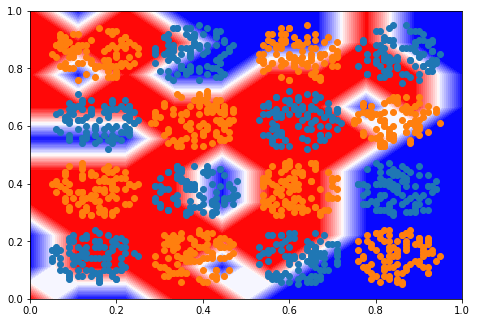

In [29]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.plot(np.ravel(dataCoords[np.where(dataLabels == 0)])[::2],
np.ravel(dataCoords[np.where(dataLabels == 0)])[1::2], ls='', marker='o')

ax.plot(np.ravel(dataCoords[np.where(dataLabels == 1)])[::2],
np.ravel(dataCoords[np.where(dataLabels == 1)])[1::2], ls='', marker='o')

X = np.linspace(0, 1, num=10)
Z = np.zeros((len(X), len(X)))

# Contour map
for j in range(len(X)):
    for k in range(len(X)):
        # Fill Z with the labels (numerical values)
        # the inner loop goes over the columns of Z,
        # which corresponds to sweeping x-values
        # Therefore, the role of j,k is flipped in the signature
        Z[j, k] = predict_qubitF( np.array([X[k], X[j]]),currentParams,[18,2])
        
ax.contourf(X, X, Z, cmap='bwr', levels=30)